In [6]:
print("Nguyễn Nguyên Huy - 6351071030")

Nguyễn Nguyên Huy - 6351071030


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import tree


In [50]:
'''
Nhập dữ liệu đầu vào và cho biết số lượng dữ liệu huấn luyện (tương ứng với file
adult.data.csv) và số lượng dữ liệu kiểm thử (tương ứng với file adult.test.csv)
'''
path_train = "/content/drive/MyDrive/Colab Notebooks/Data Mining/Dataset/adult.data.csv"
path_test  = "/content/drive/MyDrive/Colab Notebooks/Data Mining/Dataset/adult.test.csv"

train_df = pd.read_csv(path_train,
                       skipinitialspace=True,
                       na_values='?')

test_df = pd.read_csv(path_test,
                      skipinitialspace=True,
                      na_values='?')

print("Số lượng dữ liệu huấn luyện:", len(train_df))
print("Số lượng dữ liệu kiểm thử:", len(test_df))


Số lượng dữ liệu huấn luyện: 32561
Số lượng dữ liệu kiểm thử: 16281


In [53]:
'''
Tiến hành tiền xử lý dữ liệu:
• Xóa những dòng có chứa dữ liệu trống, biết rằng dữ liệu trống được ký hiệu bằng
dấu ‘?’.
• Xóa cột final weight ‘fnlwgt’ trong dữ liệu huấn luyện vì cột này không có trong
dữ liệu kiểm thử.
• Nối dữ liệu huấn luyện và kiểm thử lại với nhau để phục vụ các bước tiếp theo.
'''
if 'fnlwgt' in train_df.columns:
    train_df = train_df.drop('fnlwgt', axis=1)
    print("Đã xóa cột fnlwgt trong train")
else:
    print("Train không có cột fnlwgt")

# Kiểm tra lại để chắc chắn 2 bộ dữ liệu có cùng các cột
assert list(train_df.columns) == list(test_df.columns), "Hai bộ dữ liệu vẫn còn cột khác nhau!"
print("Sau khi xóa fnlwgt → cả hai bộ đều có chung các cột")

print(f"Train missing trước drop: {train_df.isna().sum().sum()}")
print(f"Test  missing trước drop: {test_df.isna().sum().sum()}")

train_df = train_df.dropna(how='any')
test_df  = test_df.dropna(how='any')

print(f"Train shape sau drop: {train_df.shape}")
print(f"Test  shape sau drop: {test_df.shape}")

combined_df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nKết quả cuối cùng - combined_df shape: {combined_df.shape}")
print("5 dòng đầu tiên của combined_df:")
combined_df.head()


Train không có cột fnlwgt
Sau khi xóa fnlwgt → cả hai bộ đều có chung các cột
Train missing trước drop: 0
Test  missing trước drop: 0
Train shape sau drop: (30162, 14)
Test  shape sau drop: (15060, 14)

Kết quả cuối cùng - combined_df shape: (45222, 14)
5 dòng đầu tiên của combined_df:


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


combined_df shape: (45222, 14)
Các cột hiện có:
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Các cột số: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


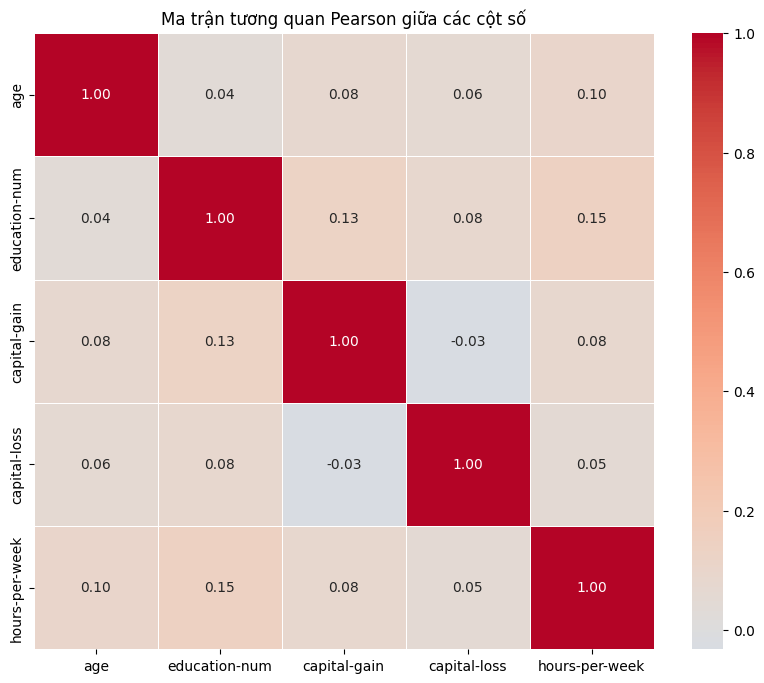


Các cặp cột có |Pearson| > 0.7:
  → Không có cặp nào vượt ngưỡng!
Không có cặp cột số nào có hệ số Pearson vượt ngưỡng 0.7 → giữ nguyên tất cả cột số


In [59]:
'''
Khảo sát độ tương đồng giữa các cột với nhau bằng công thức Pearson. Những cột
nào có giá trị tương đồng cao thì hãy loại bỏ.
'''
print("combined_df shape:", combined_df.shape)
print("Các cột hiện có:")
print(combined_df.columns.tolist())

numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
print(f"\nCác cột số: {numeric_cols.tolist()}")

numeric_df = combined_df[numeric_cols]

# Tính ma trận tương quan Pearson
corr_matrix = numeric_df.corr(method='pearson')

# Hiển thị ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title("Ma trận tương quan Pearson giữa các cột số")
plt.show()

threshold = 0.7  # Ngưỡng phổ biến

# Tạo mask để chỉ lấy nửa trên của ma trận (tránh lặp)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((col_i, col_j, corr_val))

print(f"\nCác cặp cột có |Pearson| > {threshold}:")
if high_corr_pairs:
    for col1, col2, val in high_corr_pairs:
        print(f"  - {col1} vs {col2}: {val:.3f}")
else:
    print("  → Không có cặp nào vượt ngưỡng!")

print("Không có cặp cột số nào có hệ số Pearson vượt ngưỡng 0.7 → giữ nguyên tất cả cột số")

In [60]:
'''
Tách các cột dữ liệu thành hai phần, một phần chứa các thuộc tính bình thường, một
phần chứa riêng thuộc tính quyết định.
'''
target_column = 'income'

if target_column not in combined_df.columns:
    raise ValueError(f"Cột '{target_column}' không tồn tại! Kiểm tra lại tên cột.")

# Tách features (X) và target (y)
X = combined_df.drop(columns=[target_column])
y = combined_df[target_column]

print(f"\nTách dữ liệu thành công!")
print(f"X (features) shape: {X.shape}")
print(f"y (target)  shape: {y.shape}")

print("\nPhân bố nhãn trong y:")
print(y.value_counts())

# Nếu có dấu chấm ở cuối (ví dụ: <=50K.), cần làm sạch
if y.dtype == 'object':
    # Loại bỏ dấu chấm và khoảng trắng thừa
    y = y.str.replace('.', '', regex=False).str.strip()
    print("\nĐã làm sạch dấu chấm trong cột income")
    print(y.value_counts())

data_split = {
    'X': X.copy(),
    'y': y.copy()
}

print(f"\nĐã lưu vào biến data_split['X'] và data_split['y']")



Tách dữ liệu thành công!
X (features) shape: (45222, 13)
y (target)  shape: (45222,)

Phân bố nhãn trong y:
income
<=50K    34014
>50K     11208
Name: count, dtype: int64

Đã làm sạch dấu chấm trong cột income
income
<=50K    34014
>50K     11208
Name: count, dtype: int64

Đã lưu vào biến data_split['X'] và data_split['y']


In [63]:
'''
Chuyển đổi các cột không phải dạng số về dạng one-hot vector để phù hợp với đầu
vào của thư viện.
'''
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nCác kiểu dữ liệu trong X:")
print(X.dtypes)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols     = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCột categorical cần encode: {categorical_cols}")
print(f"Cột numeric giữ nguyên: {numeric_cols}")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded = X_encoded.astype('int64')

print(f"\nSau one-hot encoding:")
print(f"X_encoded shape: {X_encoded.shape}")
print(f"Số cột mới: {X_encoded.shape[1]} (tăng do dummy variables)")

print("\nKiểu dữ liệu sau encoding:")
print(X_encoded.dtypes.value_counts())
assert X_encoded.select_dtypes(exclude=[np.number]).empty, "Vẫn còn cột không phải số!"
print("Tất cả cột đã được chuyển thành số → Sẵn sàng cho mô hình!")

print("\n3 dòng đầu của X_encoded:")
X_encoded.head(3)

X shape: (45222, 13)
y shape: (45222,)

Các kiểu dữ liệu trong X:
age                int64
workclass         object
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

Cột categorical cần encode: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Cột numeric giữ nguyên: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Sau one-hot encoding:
X_encoded shape: (45222, 95)
Số cột mới: 95 (tăng do dummy variables)

Kiểu dữ liệu sau encoding:
int64    95
Name: count, dtype: int64
Tất cả cột đã được chuyển thành số → Sẵn sàng cho mô hình!

3 dòng đầu của X_encoded:


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [66]:
'''
Tách các dòng dữ liệu ra thành hai phần huấn luyện và kiểm thử như ban đầu.
'''
y_clean = y.str.replace('.', '', regex=False).str.strip()

# Encode: <=50K → 0, >50K → 1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_clean)

print(f"\nĐã encode xong! Classes: {le.classes_}")
print("0 →", le.classes_[0])
print("1 →", le.classes_[1])
print(f"y_encoded shape: {y_encoded.shape}")
print("5 giá trị đầu của y_encoded:", y_encoded[:5])

train_size = len(train_df.dropna())  # hoặc len(train_df) nếu đã dropna trước
test_size  = len(test_df.dropna())

print(f"train_size: {train_size}")
print(f"test_size : {test_size}")
print(f"Tổng: {train_size + test_size} == {len(combined_df)} ? → {train_size + test_size == len(combined_df)}")

X_train = X_encoded.iloc[:train_size].copy()
X_test  = X_encoded.iloc[train_size:].copy()

y_train = y_encoded[:train_size]
y_test  = y_encoded[train_size:]

print(f"\nTách dữ liệu thành công!")
print(f"X_train: {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test : {y_test.shape}")

train_labels = pd.Series(y_train).map({0: le.classes_[0], 1: le.classes_[1]})
test_labels  = pd.Series(y_test).map({0: le.classes_[0], 1: le.classes_[1]})

print("\nPhân bố nhãn trong train:")
print(train_labels.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

print("\nPhân bố nhãn trong test:")
print(test_labels.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Đã encode xong! Classes: ['<=50K' '>50K']
0 → <=50K
1 → >50K
y_encoded shape: (45222,)
5 giá trị đầu của y_encoded: [0 0 0 0 0]
train_size: 30162
test_size : 15060
Tổng: 45222 == 45222 ? → True

Tách dữ liệu thành công!
X_train: (30162, 95)
X_test : (15060, 95)
y_train: (30162,)
y_test : (15060,)

Phân bố nhãn trong train:
<=50K    75.11%
>50K     24.89%
Name: proportion, dtype: object

Phân bố nhãn trong test:
<=50K    75.43%
>50K     24.57%
Name: proportion, dtype: object


In [67]:
data_split = {
    'X_train': X_train,
    'X_test':  X_test,
    'y_train': y_train,
    'y_test':  y_test,
    'label_encoder': le,
    'feature_names': X_train.columns.tolist()
}

print("Đã lưu vào biến data_split")

Đã lưu vào biến data_split


Đang huấn luyện cây ID3...
Huấn luyện xong!
Độ sâu cây: 52
Số node lá: 5380

Accuracy của ID3: 0.8142 (81.42%)


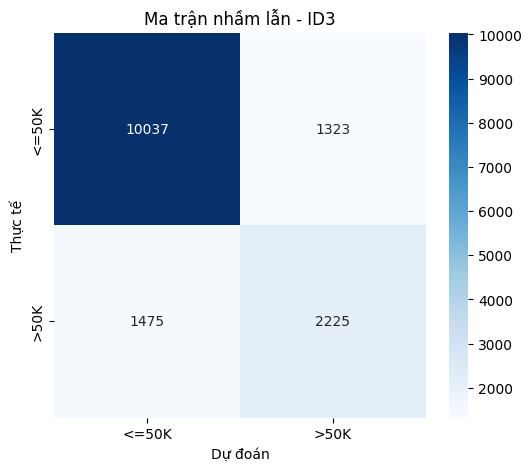


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

       <=50K       0.87      0.88      0.88     11360
        >50K       0.63      0.60      0.61      3700

    accuracy                           0.81     15060
   macro avg       0.75      0.74      0.75     15060
weighted avg       0.81      0.81      0.81     15060

Cây ID3 (một phần - 3 cấp đầu):
|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7073.50
|   |   |--- education-num <= 12.50
|   |   |   |--- age <= 28.50
|   |   |   |   |--- truncated branch of depth 17
|   |   |   |--- age >  28.50
|   |   |   |   |--- truncated branch of depth 42
|   |   |--- education-num >  12.50
|   |   |   |--- age <= 27.50
|   |   |   |   |--- truncated branch of depth 26
|   |   |   |--- age >  27.50
|   |   |   |   |--- truncated branch of depth 35
|   |--- capital-gain >  7073.50
|   |   |--- capital-gain <= 8296.00
|   |   |   |--- education-num <= 11.50
|   |   |   |  

In [73]:
'''
Xây dựng cây ID3 dựa trên dữ liệu huấn luyện và sau đó tiến hành kiểm thử kết quả
của cây bằng ma trận nhầm lẫn. Biểu diễn cây vào trong kết quả thực hiện.
'''

id3_model = DecisionTreeClassifier(
    criterion='entropy',    # ID3: dùng entropy
    random_state=42,
    max_depth=None,         # không giới hạn độ sâu → cây đầy đủ
    min_samples_split=2,
    min_samples_leaf=1
)

print("Đang huấn luyện cây ID3...")
id3_model.fit(X_train, y_train)
print("Huấn luyện xong!")
print(f"Độ sâu cây: {id3_model.get_depth()}")
print(f"Số node lá: {id3_model.get_n_leaves()}")

y_pred = id3_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy của ID3: {accuracy:.4f} ({accuracy*100:.2f}%)")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Ma trận nhầm lẫn - ID3')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

print("\nBáo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Cây ID3 (một phần - 3 cấp đầu):")
text_repr = tree.export_text(id3_model, feature_names=X_train.columns.tolist(), max_depth=3)
print(text_repr)

Đang huấn luyện cây CART...
Huấn luyện xong!
Độ sâu cây: 46
Số node lá: 5438

Accuracy của CART: 0.8123 (81.23%)


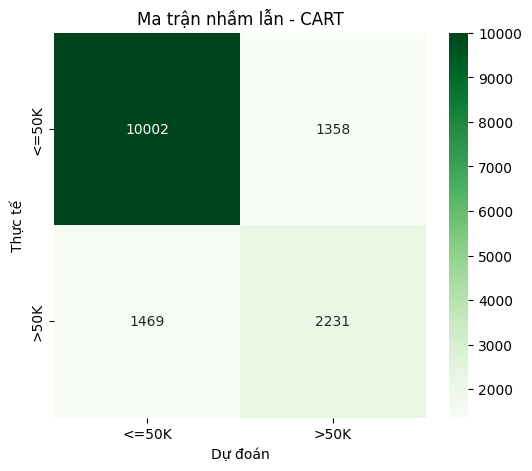


Báo cáo phân loại (CART):
              precision    recall  f1-score   support

       <=50K       0.87      0.88      0.88     11360
        >50K       0.62      0.60      0.61      3700

    accuracy                           0.81     15060
   macro avg       0.75      0.74      0.74     15060
weighted avg       0.81      0.81      0.81     15060

Cây CART (3 cấp đầu - minh họa):
|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7073.50
|   |   |--- education-num <= 12.50
|   |   |   |--- capital-loss <= 2218.50
|   |   |   |   |--- truncated branch of depth 30
|   |   |   |--- capital-loss >  2218.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- education-num >  12.50
|   |   |   |--- hours-per-week <= 43.50
|   |   |   |   |--- truncated branch of depth 25
|   |   |   |--- hours-per-week >  43.50
|   |   |   |   |--- truncated branch of depth 27
|   |--- capital-gain >  7073.50
|   |   |--- age <= 20.00
|   |   |   |--- class: 0
|   |   |--- 

In [74]:
'''
Lặp lại yêu cầu 7 đối với cây CART.
'''
cart_model = DecisionTreeClassifier(
    criterion='gini',       # CART: dùng Gini
    random_state=42,
    max_depth=None,         # không giới hạn → cây đầy đủ
    min_samples_split=2,
    min_samples_leaf=1
)

print("Đang huấn luyện cây CART...")
cart_model.fit(X_train, y_train)
print("Huấn luyện xong!")
print(f"Độ sâu cây: {cart_model.get_depth()}")
print(f"Số node lá: {cart_model.get_n_leaves()}")

y_pred_cart = cart_model.predict(X_test)

accuracy_cart = accuracy_score(y_test, y_pred_cart)
print(f"\nAccuracy của CART: {accuracy_cart:.4f} ({accuracy_cart*100:.2f}%)")

cm_cart = confusion_matrix(y_test, y_pred_cart)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cart, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Ma trận nhầm lẫn - CART')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

print("\nBáo cáo phân loại (CART):")
print(classification_report(y_test, y_pred_cart, target_names=le.classes_))

print("Cây CART (3 cấp đầu - minh họa):")
text_repr_cart = tree.export_text(cart_model, feature_names=X_train.columns.tolist(), max_depth=3)
print(text_repr_cart)

Đang huấn luyện Naïve Bayes (GaussianNB)...
Huấn luyện xong!

Accuracy của Naïve Bayes: 0.8220 (82.20%)


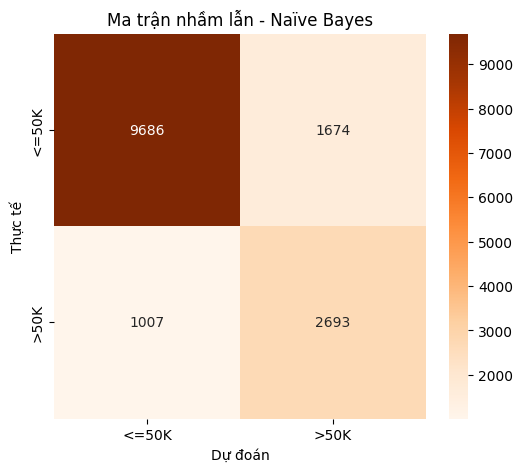


Báo cáo phân loại (Naïve Bayes):
              precision    recall  f1-score   support

       <=50K       0.91      0.85      0.88     11360
        >50K       0.62      0.73      0.67      3700

    accuracy                           0.82     15060
   macro avg       0.76      0.79      0.77     15060
weighted avg       0.83      0.82      0.83     15060



In [77]:
'''
Xây dựng mô hình phân lớp bằng thuật toán Naïve Bayes và kiểm tra kết quả đạt
được.
'''
nb_model = GaussianNB()

print("Đang huấn luyện Naïve Bayes (GaussianNB)...")
nb_model.fit(X_train, y_train)
print("Huấn luyện xong!")

y_pred_nb = nb_model.predict(X_test)

# ------------------------------------------------------------------
# 3. Tính accuracy
# ------------------------------------------------------------------
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"\nAccuracy của Naïve Bayes: {accuracy_nb:.4f} ({accuracy_nb*100:.2f}%)")

# ------------------------------------------------------------------
# 4. Ma trận nhầm lẫn
# ------------------------------------------------------------------
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Ma trận nhầm lẫn - Naïve Bayes')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# ------------------------------------------------------------------
# 5. Báo cáo chi tiết
# ------------------------------------------------------------------
print("\nBáo cáo phân loại (Naïve Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))


TỔNG KẾT HIỆU SUẤT 3 MÔ HÌNH:


,Mô hình,Accuracy,Precision (>50K),Recall (>50K),F1-score (>50K)
0,ID3 (entropy),0.8142,0.627,0.601,0.614
1,CART (gini),0.8123,0.622,0.603,0.612
2,Naïve Bayes,0.8220,0.617,0.728,0.668


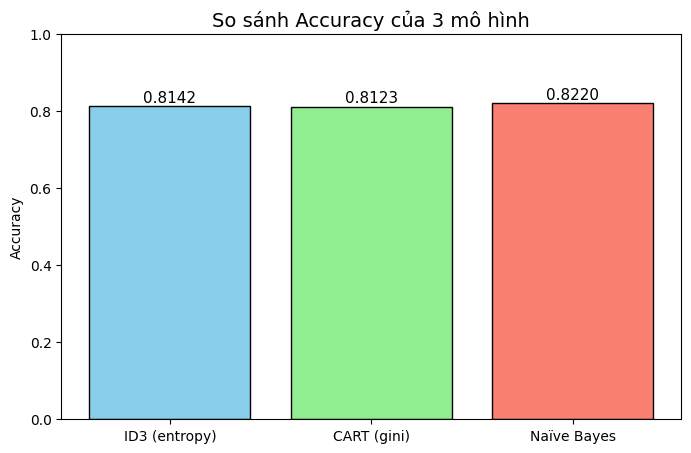

In [79]:
'''
So sánh kết quả của các mô hình trên.
'''
report_id3  = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
report_cart = classification_report(y_test, y_pred_cart, output_dict=True, target_names=le.classes_)
report_nb   = classification_report(y_test, y_pred_nb, output_dict=True, target_names=le.classes_)

results = {
    'Mô hình': ['ID3 (entropy)', 'CART (gini)', 'Naïve Bayes'],
    'Accuracy': [accuracy, accuracy_cart, accuracy_nb],
    'Precision (>50K)': [
        report_id3['>50K']['precision'],
        report_cart['>50K']['precision'],
        report_nb['>50K']['precision']
    ],
    'Recall (>50K)': [
        report_id3['>50K']['recall'],
        report_cart['>50K']['recall'],
        report_nb['>50K']['recall']
    ],
    'F1-score (>50K)': [
        report_id3['>50K']['f1-score'],
        report_cart['>50K']['f1-score'],
        report_nb['>50K']['f1-score']
    ]
}

summary_df = pd.DataFrame(results)
summary_df['Accuracy'] = summary_df['Accuracy'].round(4)
for col in ['Precision (>50K)', 'Recall (>50K)', 'F1-score (>50K)']:
    summary_df[col] = summary_df[col].round(3)

print("\nTỔNG KẾT HIỆU SUẤT 3 MÔ HÌNH:")
display(summary_df)

plt.figure(figsize=(8,5))
bars = plt.bar(summary_df['Mô hình'], summary_df['Accuracy'],
               color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')
plt.title('So sánh Accuracy của 3 mô hình', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{height:.4f}', ha='center', fontsize=11)

plt.show()